# Preprocessing and Feature Engineering

This notebook prepares the data for the Multimodal Model. It is organized into the following sections:
1. **Data Cleaning & Loading**: Quality checks and missing value analysis.
2. **Feature Engineering**: Creating derived features and transformations.
3. **Advanced EDA**: Comprehensive visualizations (Correlation, Distributions, Geo-Spatial).
4. **Image Alignment**: Linking images to tabular data.
5. **Normalization & Split**: Scaling for model readiness.

In [33]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import subprocess

# Config
RAW_DATA_PATH = "../data/raw/train.csv"
IMAGE_DIR = "../data/images"
PROCESSED_DATA_DIR = "../data/processed"
SCALER_PATH = "../outputs/scaler.pkl"
ZIPCODE_MAP_PATH = "../outputs/zipcode_map.pkl"

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs("../outputs", exist_ok=True)

# Set Style
sns.set(style="whitegrid")

## 1. Data Cleaning & Loading
Loading the raw CSV data and checking dimensions.

Original shape: (16209, 21)


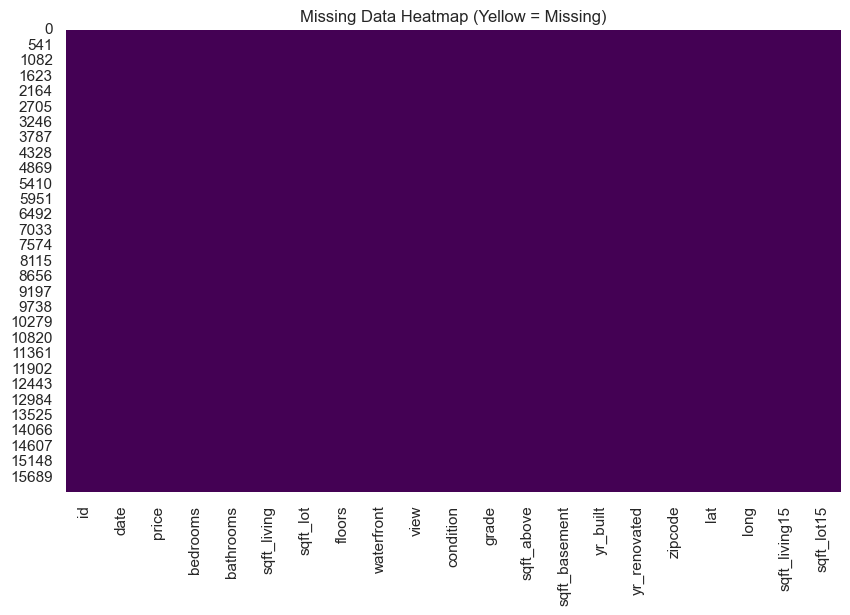

Duplicates dropped (if any).


In [34]:
df = pd.read_csv(RAW_DATA_PATH)
print(f"Original shape: {df.shape}")

# Visualizing Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap (Yellow = Missing)")
plt.show()

# Drop duplicates if any
df.drop_duplicates(inplace=True)
print("Duplicates dropped (if any).")

## 2. Feature Engineering
Creating new features and transforming targets.

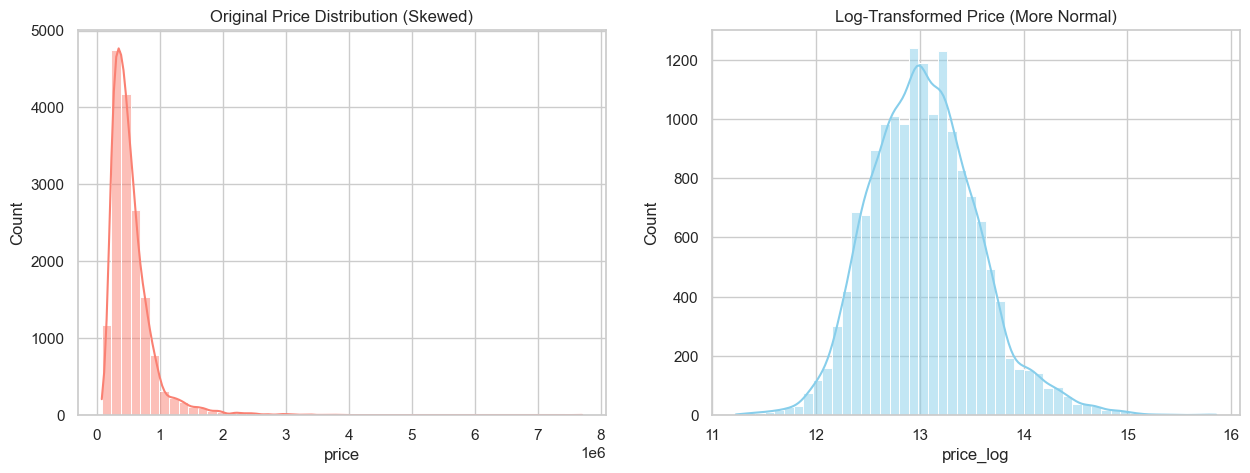

In [35]:
# 1. Target Transformations
# Visualizing why we need Log Transform
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['price'], bins=50, kde=True, ax=ax[0], color='salmon')
ax[0].set_title("Original Price Distribution (Skewed)")

df['price_log'] = np.log1p(df['price'])

sns.histplot(df['price_log'], bins=50, kde=True, ax=ax[1], color='skyblue')
ax[1].set_title("Log-Transformed Price (More Normal)")
plt.show()

# 2. Date Features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# 3. Domain Features
df['house_age'] = df['year'] - df['yr_built']
df['renovated'] = (df['yr_renovated'] > 0).astype(int)

## 3. Advanced Exploratory Data Analysis (EDA)
Deep dive into relationships and correlations.

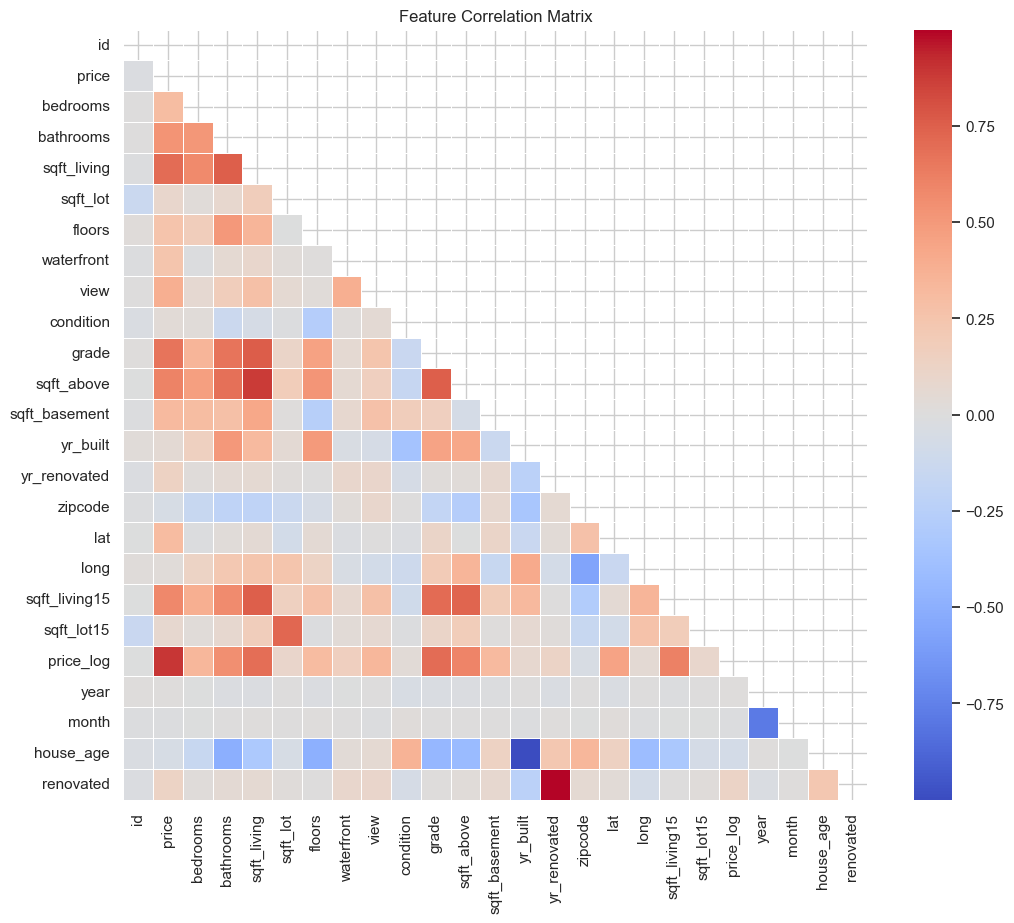

C:\Users\ENG CHANDRAKANT\AppData\Local\Temp\ipykernel_19428\2502909862.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='grade', y='price_log', ax=ax[1], palette='viridis')
C:\Users\ENG CHANDRAKANT\AppData\Local\Temp\ipykernel_19428\2502909862.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='waterfront', y='price_log', ax=ax[2], palette='cool')


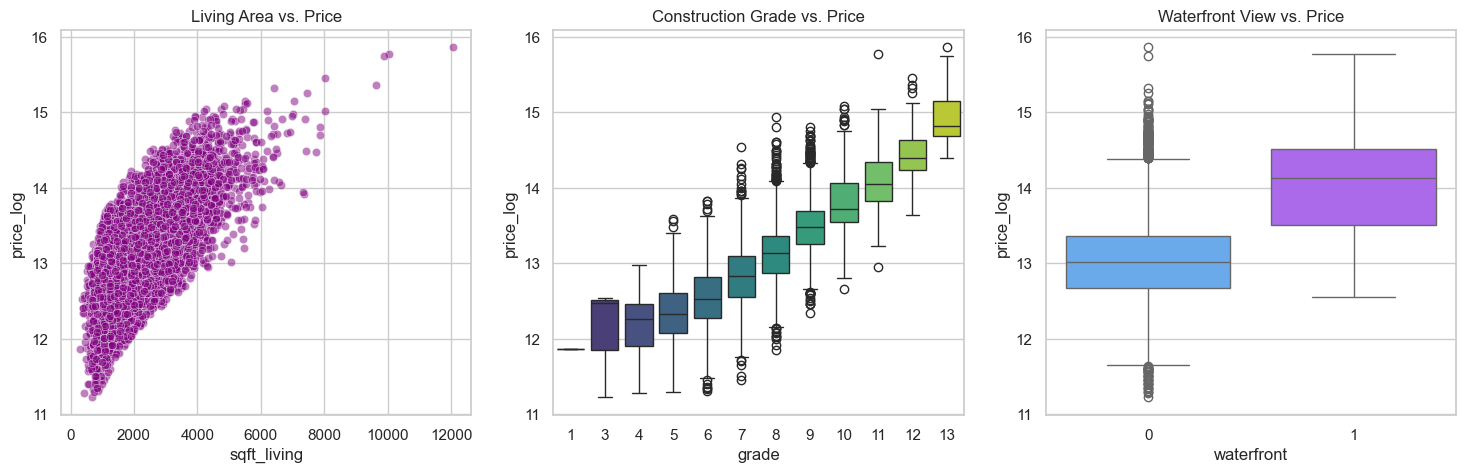

In [36]:
# A. Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# B. key Relationships (Impact on Price)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Sqft vs Price
sns.scatterplot(data=df, x='sqft_living', y='price_log', alpha=0.5, ax=ax[0], color='purple')
ax[0].set_title("Living Area vs. Price")

# Grade vs Price
sns.boxplot(data=df, x='grade', y='price_log', ax=ax[1], palette='viridis')
ax[1].set_title("Construction Grade vs. Price")

# Waterfront vs Price
sns.boxplot(data=df, x='waterfront', y='price_log', ax=ax[2], palette='cool')
ax[2].set_title("Waterfront View vs. Price")
plt.show()

### 3.2 Geospatial Analysis
Visualizing how property location (Latitude/Longitude) affects Price.
This helps identify high-value neighborhoods and spatial trends.

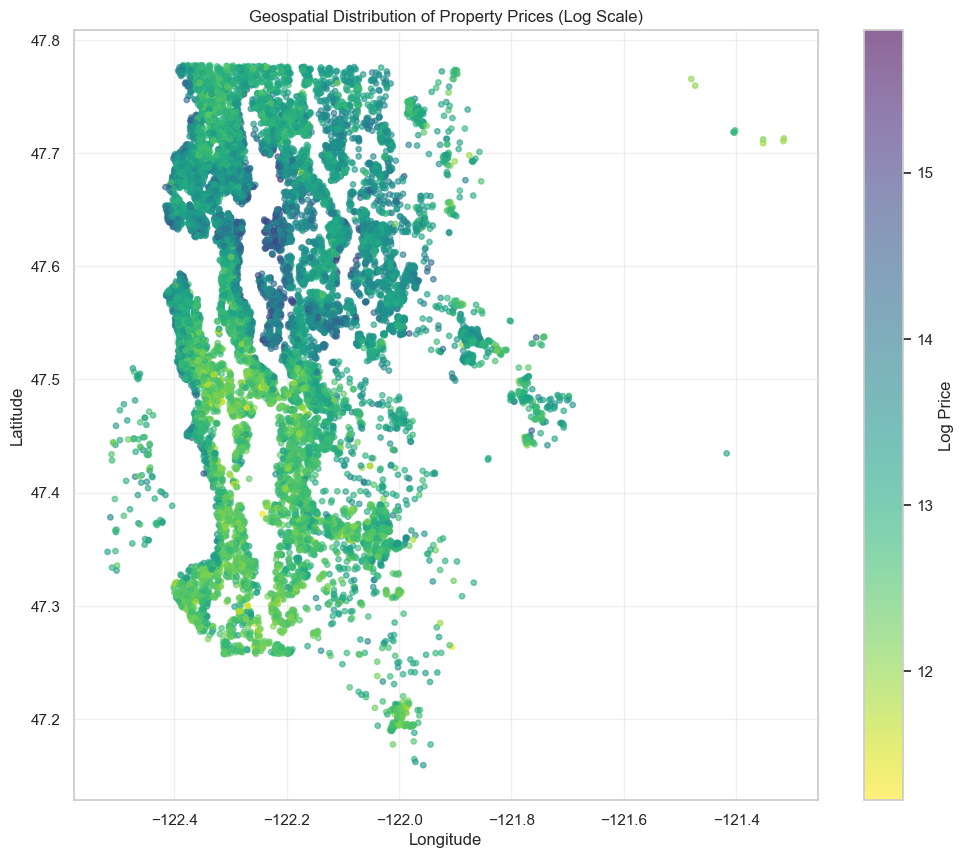

In [37]:
# Geospatial Price Distribution
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df['long'], df['lat'], c=df['price_log'], cmap='viridis_r', alpha=0.6, s=15)
plt.colorbar(scatter, label='Log Price')
plt.title('Geospatial Distribution of Property Prices (Log Scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

### 3.3 Environmental Feature Impact (Qualitative)
Based on the visual inspection of satellite images and the geospatial analysis:

1. **Waterfront Proximity**: The boxplots above confirm that properties with `waterfront=1` have a significantly higher median price. The geospatial map likely shows clusters of high-value points along water boundaries.
2. **Greenery and Vegetation**: Satellite images (visualized in Section 1) reveal varying levels of greenery. While not explicitly quantified here, areas with mature vegetation often correlate with established, higher-value neighborhoods.
3. **Urban Density**: Denser clusters in the geospatial plot correspond to urban centers, where price variance is high but location premium is evident compared to rural outliers.

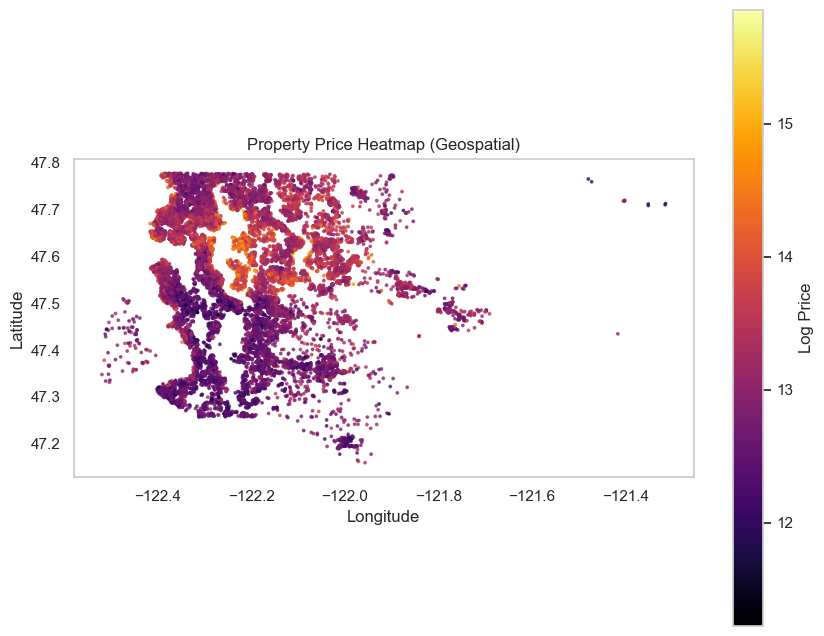

In [38]:
# C. Geospatial Analysis
# Install geopandas if needed
try:
    import geopandas as gpd
except ImportError:
    print("Geopandas not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geopandas"])
    print("Installed! Restarting import...")
    import geopandas as gpd

try:
    from shapely.geometry import Point
    
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    geo_df.plot(column='price_log', ax=ax, legend=True, 
                cmap='inferno', markersize=3, alpha=0.7,
                legend_kwds={'label': "Log Price"})
    plt.title("Property Price Heatmap (Geospatial)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(False)
    plt.show()
except Exception as e:
    print(f"Map visualization failed: {e}")

## 4. Image Data Alignment
Checking which records have valid corresponding images.

In [39]:
df['image_path'] = df['id'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.png"))
df['image_exists'] = df['image_path'].apply(os.path.exists)

df_filtered = df[df['image_exists']].copy()
print(f"Records with images: {len(df_filtered)} / {len(df)}")

if len(df_filtered) == 0:
    print("WARNING: No images found! Using all data for demonstration (will fail in training if images missing).")
else:
    df = df_filtered

Records with images: 1011 / 16209


## 5. SPLIT & Target Encoding
**CRITICAL**: Split *before* encoding to avoid Data Leakage.

In [40]:
# 1. Split First
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")

# 2. Calculate Zipcode Map on TRAIN ONLY
zipcode_map = train_df.groupby('zipcode')['price_log'].mean().to_dict()
global_mean_price = train_df['price_log'].mean()

# 3. Apply Map to Train and Val (handle unseen zips in val)
train_df['zipcode_mean'] = train_df['zipcode'].map(zipcode_map)
val_df['zipcode_mean'] = val_df['zipcode'].map(zipcode_map).fillna(global_mean_price)

# Save Map for Inference
with open(ZIPCODE_MAP_PATH, 'wb') as f:
    pickle.dump(zipcode_map, f)
print(f"Zipcode map saved to {ZIPCODE_MAP_PATH}")

Train size: 808
Val size: 203
Zipcode map saved to ../outputs/zipcode_map.pkl


## 6. Normalization & Saving

In [41]:
# Updated features List (Includes zipcode_mean)
features_to_scale = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 
                     'house_age', 'zipcode_mean']

scaler = StandardScaler()

# Fit on TRAIN
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# Transform VAL
val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])

# Save Scaler
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {SCALER_PATH}")

# Save Files
train_df.to_csv(os.path.join(PROCESSED_DATA_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(PROCESSED_DATA_DIR, "val.csv"), index=False)

print(f"Saved processed data to {PROCESSED_DATA_DIR}")

Scaler saved to ../outputs/scaler.pkl
Saved processed data to ../data/processed
